In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import glob

1.1 Đọc và tổ chức dữ liệu

In [4]:
def load_data(af_folder, non_af_folder):
    """Load all CSV files from AF and non-AF folders"""
    af_files = glob.glob(f"{af_folder}/*.csv")
    non_af_files = glob.glob(f"{non_af_folder}/*.csv")
    
    # Load AF data
    af_data = []
    for file in af_files:
        df = pd.read_csv(file)
        df['label'] = 1  # AF = 1
        df['file_id'] = Path(file).stem
        af_data.append(df)
    
    # Load non-AF data
    non_af_data = []
    for file in non_af_files:
        df = pd.read_csv(file)
        df['label'] = 0  # non-AF = 0
        df['file_id'] = Path(file).stem
        non_af_data.append(df)
    
    return af_data, non_af_data

# Sử dụng
af_data, non_af_data = load_data("DATA AF CSV/mimic_perform_af_csv", "DATA AF CSV/mimic_perform_non_af_csv")

AF files: 19, avg length: 150001 samples
Non-AF files: 16, avg length: 150001 samples


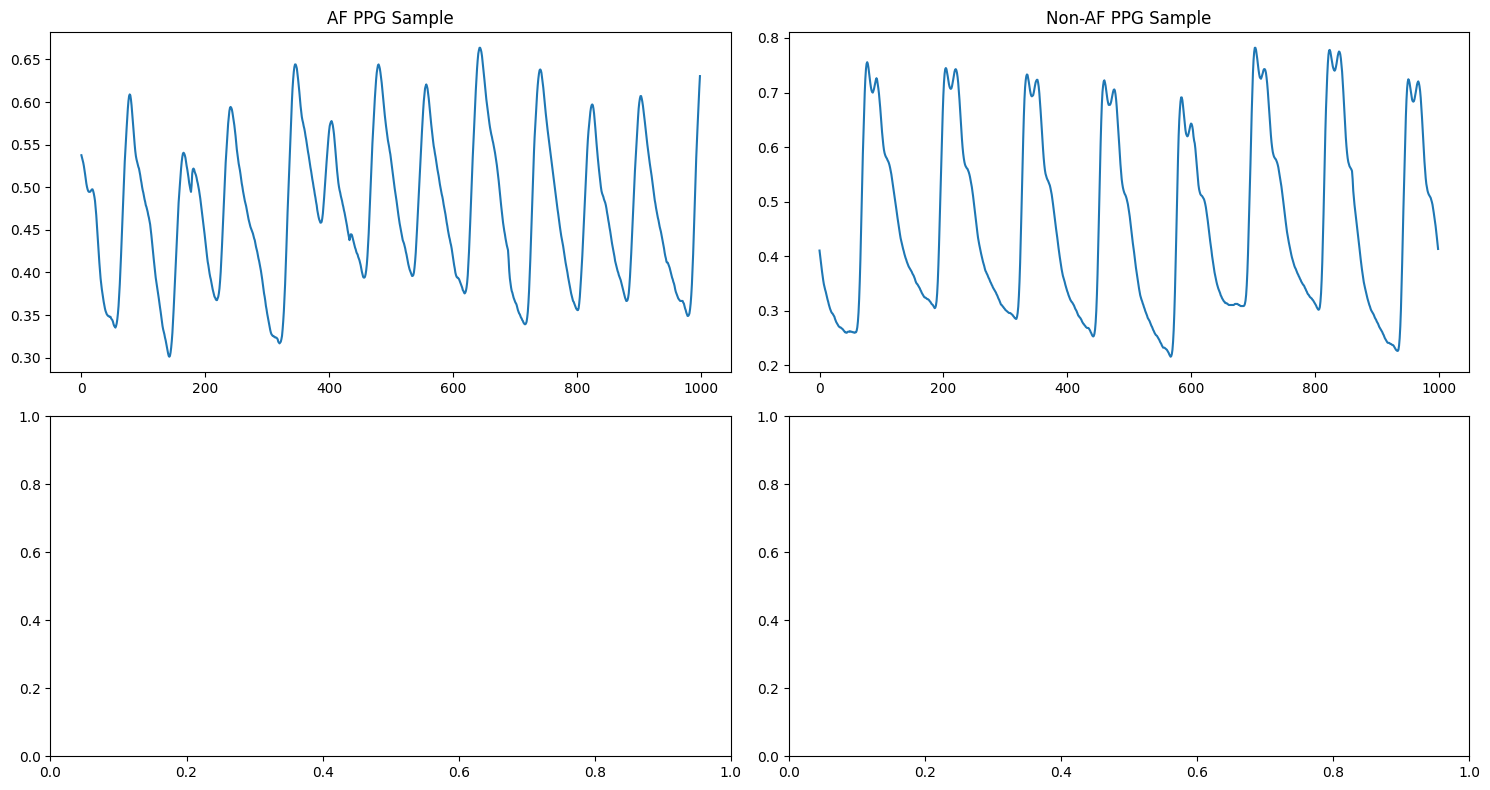

In [5]:
# Kiểm tra độ dài tín hiệu
af_lengths = [len(df) for df in af_data]
non_af_lengths = [len(df) for df in non_af_data]

print(f"AF files: {len(af_data)}, avg length: {np.mean(af_lengths):.0f} samples")
print(f"Non-AF files: {len(non_af_data)}, avg length: {np.mean(non_af_lengths):.0f} samples")

# Visualize một số tín hiệu mẫu
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
af_data[0]['PPG'][:1000].plot(ax=axes[0,0], title='AF PPG Sample')
non_af_data[0]['PPG'][:1000].plot(ax=axes[0,1], title='Non-AF PPG Sample')
plt.tight_layout()

Trích xuất đặc trưng (Feature Extraction)

In [7]:
from scipy import signal
from scipy.stats import skew, kurtosis
import numpy as np

def extract_features(ppg_signal, fs=125):
    """Simple and fast feature extraction from PPG signal"""
    features = {}
    
    # 1. Basic statistical features
    features['mean'] = np.mean(ppg_signal)
    features['std'] = np.std(ppg_signal)
    features['min'] = np.min(ppg_signal)
    features['max'] = np.max(ppg_signal)
    features['range'] = features['max'] - features['min']
    features['skewness'] = skew(ppg_signal)
    features['kurtosis'] = kurtosis(ppg_signal)
    features['rms'] = np.sqrt(np.mean(ppg_signal**2))
    
    # 2. Peak-based features
    try:
        peaks, _ = signal.find_peaks(ppg_signal, height=features['mean'], distance=fs//3)
        features['num_peaks'] = len(peaks)
        
        if len(peaks) > 1:
            # Heart rate features
            rr_intervals = np.diff(peaks) / fs
            features['mean_hr'] = 60 / np.mean(rr_intervals)
            features['std_hr'] = np.std(60 / rr_intervals)
            features['rmssd'] = np.sqrt(np.mean(np.diff(rr_intervals)**2))
        else:
            features.update({'mean_hr': 0, 'std_hr': 0, 'rmssd': 0})
    except:
        features.update({'num_peaks': 0, 'mean_hr': 0, 'std_hr': 0, 'rmssd': 0})
    
    # 3. Frequency domain features
    try:
        f, psd = signal.welch(ppg_signal, fs=fs, nperseg=min(256, len(ppg_signal)//4))
        
        # Power in frequency bands
        lf_mask = (f >= 0.04) & (f < 0.15)  # Low frequency
        hf_mask = (f >= 0.15) & (f < 0.4)   # High frequency
        
        features['lf_power'] = np.trapz(psd[lf_mask], f[lf_mask]) if np.any(lf_mask) else 0
        features['hf_power'] = np.trapz(psd[hf_mask], f[hf_mask]) if np.any(hf_mask) else 0
        features['lf_hf_ratio'] = features['lf_power'] / (features['hf_power'] + 1e-6)
        features['dominant_freq'] = f[np.argmax(psd)]
    except:
        features.update({'lf_power': 0, 'hf_power': 0, 'lf_hf_ratio': 0, 'dominant_freq': 0})
    
    # 4. Other simple features
    features['zero_crossings'] = len(np.where(np.diff(np.sign(ppg_signal - features['mean'])))[0])
    features['energy'] = np.sum(ppg_signal**2)
    
    return features

# Hàm xử lý tất cả files với progress bar
from tqdm import tqdm

def extract_all_features(data_list, label_name=""):
    feature_list = []
    print(f"Extracting features from {len(data_list)} {label_name} files...")
    
    for df in tqdm(data_list):
        try:
            features = extract_features(df['PPG'].values)
            features['label'] = df['label'].iloc[0]
            features['file_id'] = df['file_id'].iloc[0]
            feature_list.append(features)
        except Exception as e:
            print(f"Error processing file: {e}")
            continue
    
    return pd.DataFrame(feature_list)

# Sử dụng:
af_features = extract_all_features(af_data, "AF")
non_af_features = extract_all_features(non_af_data, "non-AF")
all_features = pd.concat([af_features, non_af_features], ignore_index=True)

Extracting features from 19 AF files...


100%|██████████| 19/19 [00:00<00:00, 26.41it/s]


Extracting features from 16 non-AF files...


100%|██████████| 16/16 [00:00<00:00, 27.05it/s]


Tiền xử lý dữ liệu

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Tách features và labels
feature_columns = [col for col in all_features.columns if col not in ['label', 'file_id']]
X = all_features[feature_columns]
y = all_features['label']

# Xử lý missing values
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Chia dữ liệu train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

Lựa chọn và huấn luyện mô hình

In [10]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Dictionary các mô hình
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'MLP': MLPClassifier(hidden_layer_sizes=(100, 50), random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Huấn luyện và đánh giá các mô hình
results = {}
for name, model in models.items():
    # Huấn luyện
    model.fit(X_train, y_train)
    
    # Dự đoán
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Đánh giá
    auc = roc_auc_score(y_test, y_pred_proba)
    results[name] = {
        'model': model,
        'auc': auc,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    
    print(f"\n{name} Results:")
    print(f"AUC: {auc:.4f}")
    print(classification_report(y_test, y_pred))

# Tìm mô hình tốt nhất
best_model_name = max(results.keys(), key=lambda k: results[k]['auc'])
print(f"\nBest Model: {best_model_name} (AUC: {results[best_model_name]['auc']:.4f})")


Random Forest Results:
AUC: 0.8333
              precision    recall  f1-score   support

           0       0.50      0.67      0.57         3
           1       0.67      0.50      0.57         4

    accuracy                           0.57         7
   macro avg       0.58      0.58      0.57         7
weighted avg       0.60      0.57      0.57         7


SVM Results:
AUC: 0.5833
              precision    recall  f1-score   support

           0       0.33      0.33      0.33         3
           1       0.50      0.50      0.50         4

    accuracy                           0.43         7
   macro avg       0.42      0.42      0.42         7
weighted avg       0.43      0.43      0.43         7


Logistic Regression Results:
AUC: 0.4167
              precision    recall  f1-score   support

           0       0.40      0.67      0.50         3
           1       0.50      0.25      0.33         4

    accuracy                           0.43         7
   macro avg       0.45 

Tinh chỉnh siêu tham số

In [11]:
from sklearn.model_selection import GridSearchCV

# Ví dụ với Random Forest
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_params,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)
print(f"Best RF parameters: {rf_grid.best_params_}")
print(f"Best RF AUC: {rf_grid.best_score_:.4f}")

Best RF parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best RF AUC: 0.8778


Đánh giá và validation:

In [12]:
# Cross-validation
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
    results[best_model_name]['model'], 
    X_scaled, y, 
    cv=5, 
    scoring='roc_auc'
)

print(f"CV AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Feature importance
if hasattr(results[best_model_name]['model'], 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': results[best_model_name]['model'].feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 10 Important Features:")
    print(feature_importance.head(10))

CV AUC: 0.7417 (+/- 0.3667)

Top 10 Important Features:
           feature  importance
10          std_hr    0.230810
11           rmssd    0.188988
6         kurtosis    0.144005
9          mean_hr    0.088355
16  zero_crossings    0.061837
8        num_peaks    0.060739
5         skewness    0.042070
4            range    0.040967
1              std    0.031697
7              rms    0.028769
